In [127]:
import numpy as np
import random
from typing import Dict, List, Set
import logging

import pandas as pd
import seaborn as sns

# Step for ACO + Set Cover Code

In [2]:
""""Data process"""

class DataReader:


    def __init__(self, file):
        """
        DataReader Initialization
        
        Args:
            file (str): filepath 
        """
        self.file = file
        self.data = self._readTXT()
        self.universe, self.sets = tuple( int(i) for i in self.data[0].split() ) 
        self.sets, self.costs  = self._processTXT(self.data)

    def _readTXT(self):
        """
        Reads filepath.
        """
        with open(self.file) as f:
            data = f.readlines()
        return data

    def _processTXT(self, data):
        """
        Generate sets and costs
        
        Args:
            data (List): List of lines of data read
        
        """
        
        sets = [ [ int(j) for j in i.split()[1: ] ] for i in data[1:] ]
        costs = [ int(i.split()[0])  for i in data[1:] ]
        return  sets, costs


# Set Covering class

In [3]:
import logging


class BaseLogger:
    
    
    def __init__(self, logger_name: str = "Model Logger") -> None:
        
        self.logger_name = logger_name
        self.logger      =  logging.getLogger(self.logger_name)
        self.__logger_settings()
        # TODO: Check if the only handler needed is the StreamHandler
        if len(self.logger.handlers) > 2:
            for handler in self.logger.handlers: self.logger.removeHandler(handler)
        
        
    def __logger_settings(self) -> None:
        
        self.logger.setLevel(logging.INFO)
        logFileHandler = logging.FileHandler("./app.log",mode='w')
        consoleHandler  = logging.StreamHandler()
        logFormatter = logging.Formatter('%(name)s - %(levelname)s - [%(asctime)s] - %(message)s')
        
        consoleHandler.setFormatter(logFormatter)
        logFileHandler.setFormatter(logFormatter)
        
        self.logger.addHandler(logFileHandler)
        self.logger.addHandler(consoleHandler)


In [ ]:
# 1. Create an Empty binary vector  with the election of subsets
# 2. 

In [121]:
from collections import Counter

class SetCovering(BaseLogger):
    
    
    def __init__(self, subsets: List, costs: List) -> None:
        """ Set convering initialization
        """
        super().__init__()
        self.subsets = subsets
        self.costs   = costs
        self.universe = self.__identify_unique_items()
        self.total_set_elements = len(self.universe)
        self.total_subsets      = len(subsets)
        self.item_scores        = self.__calculate_item_scores()
        self.set_scores         = self.__calculate_set_scores()
        self.set_probabilities  = self.__calculate_set_probabilities()
        self.max_len_set        = max([len(subset) for subset in self.subsets])
    
    def __identify_unique_items(self) -> Set:
        """Find all unique elements of data structure
        
        """
        return { item for instance in self.subsets for item in instance }
    
    def __calculate_item_scores(self):
        item_counts  = dict(
            Counter([item for sublist in self.subsets for item in sublist])
        )
        
        item_values = {}
        for key, value in item_counts.items():
            item_values[key] = 1 / (value / self.total_subsets)
        
        SCORE_MAX = max(item_values.values())
        SCORE_MIN = min(item_values.values())
        
        item_scores = {}
        for key, value in item_values.items():
            item_scores[key] = SetCovering.max_min_normalizer(value, max_val = SCORE_MAX, min_val = SCORE_MIN)
            
        return item_scores

    def __calculate_set_probabilities(self):
        """Return the average score for each subset"""
        scores = [np.mean([self.item_scores[i] for i in subset])   for subset in self.subsets]
        
        return  self.__calculate_probabilities(scores)
    
    
    def __calculate_probabilities(self, vals):
        total_sum     = sum(vals)
        return [ val / total_sum  for val in vals ]
    
    def __calculate_set_scores(self):
        
        total_subsets = []
        for subset in self.subsets:
            subset_scores = [self.item_scores[i] for i in subset]
            subset_overall_score = np.average(subset_scores, weights= [item / sum(subset_scores) for item in subset_scores])
            total_subsets.append(subset_overall_score)
        return total_subsets
        
    
    def cover(self, probs = None):
        """ Create a set covering solution
        """
        
        if not probs:
            prob_dist = self.set_probabilities
        
        all_available_subsets = [*range(self.total_subsets)]
        
    
        covered = set()
        selected_subsets = []
        cost = 0
        while covered != self.universe:

            subset_idx = self.__select_set(set_list = all_available_subsets)
            subset     = set( self.subsets[subset_idx] )
            
            selected_subsets.append(subset_idx)
            covered |= subset
            
            cost += self.costs[subset_idx]
            all_available_subsets.remove(subset_idx)
            
        
        self.logger.info(f">>> Total covering cost: {cost}")
        self.logger.info(f">>> Total subsets selected: {len(selected_subsets)}")
        
        return selected_subsets, cost

        
    def __select_set(self, set_list: List, probs = None):
        """Select a set index, regarding if the set already have appended to a subset_list"""
        subset_idx = random.choices(set_list)
        return set_list[subset_idx]
    
    @staticmethod
    def max_min_normalizer(num, max_val, min_val):
        return (num - min_val) / (max_val - min_val)

            

In [141]:
pd.DataFrame({'subsets': [str(subset) for subset in set_cover_instance.subsets],
              'scores': set_cover_instance.set_scores, 
              'cost': set_cover_instance.costs}).sort_values(by = 'scores', ascending = True)

,subsets,scores,cost
1030,"[8, 14, 15, 5, 42, 96, 338, 76, 8]",0.002153,2
1058,"[8, 14, 15, 5, 42, 201, 338, 76, 8]",0.002179,2
1025,"[8, 14, 15, 5, 42, 96, 4, 35, 36]",0.002216,2
1053,"[8, 14, 15, 5, 42, 201, 4, 35, 36]",0.002239,2
1169,"[8, 14, 15, 5, 354, 96, 338, 76, 8]",0.002240,2
...,...,...,...
1824,"[6, 14, 15, 74, 417, 418, 452]",0.986759,1
321,"[5, 4, 64, 251, 241, 441]",0.991461,2
389,"[2, 7, 487]",0.993321,2
575,"[2, 7, 287]",0.993321,1


In [125]:
set_cover_instance = SetCovering(set_cover_data.sets, costs=set_cover_data.costs)

# ACO

In [54]:
%%timeit
np.random.choice(a = aco_optimizer.set_cover.subsets , p =  [i / sum(aco_optimizer.set_initial_pheromones) for i in aco_optimizer.set_initial_pheromones])

<magic-timeit>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


302 ms ± 3.29 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [95]:
random.choices( aco_optimizer.set_cover.subsets , weights =  aco_optimizer.set_initial_pheromones)

[6, 17, 74, 221, 239, 240, 250]

In [231]:
"""Ant System Metaherustic"""

import multiprocessing


class ACOptimizer(BaseLogger):
    
    def __init__(self, 
                 set_cover: SetCovering,
                 ants: int = 10,
                 evaporation_rate: float = 0.0,
                 alpha: float = 1.0,
                 beta:float = 1.0) -> None:
        
        """
        ACO algorithm initialization
        
        Args:
            saet_cover (SetCovering): set cover class with the subsets and costs
            ants (int): Number of ants in the instance
            evaporation_date (float):  pheromone's evaporation speed for each iteration
            
        """
        super().__init__()
        self.set_cover = set_cover
        self.ants = ants
        self.evaporation_rate = evaporation_rate
        self.heuristic_alpha = alpha
        self.heuristic_beta = beta
        self.set_quality = self.__calc_pheromone()
        self.set_pheromones = [ 1 / self.set_cover.total_subsets for _ in range(self.set_cover.total_subsets)]
        self.solutions = None
        
    def __str__(self):
        return "ACO(ants = {ants}, evaporation_rate = {evaporation_rate})".format(ants = self.ants, evaporation_rate = self.evaporation_rate)
    
    
    def __calc_pheromone(self):
        
        """Calculates pheromone level by each set based on the length of the set
        
        """
        
        pheromones = []
        for i, subset in enumerate(self.set_cover.subsets):
                
            length_score =  len(subset) / self.set_cover.max_len_set
            rarity_score =  self.set_cover.set_probabilities[i]
            cost_score   =  self.set_cover.costs[i]
                
            metaheuristic_information =  ( length_score / cost_score) ** self.heuristic_alpha  * rarity_score ** self.heuristic_beta
            pheromones.append(metaheuristic_information)
            
        return pheromones
            
    
    def __initialize(self):
        
        pool = ACOptimizer.make_pool()
        result = pool.map(self.set_cover.cover, [ ant for ant in range(self.ants) ])
        pool.close()
        return result
    
    def __update_probabilities(self, solutions) -> None:
        """Update probabilities based on past solutions and evaporation rate"""
        
        self.set_pheromones = [pheromone * (1 - self.evaporation_rate)  for pheromone in self.set_pheromones]
        
        for solution in solutions:
            for i, subset in enumerate(solution[0]):
                self.set_pheromones[i] += self.set_quality[i]
        
        
    def build_ant_solution(self, ant):
        
        #pool = ACOptimizer.make_pool()
        solutions = self.__set_cover_ant_solution()
        #pool.close()
        return solutions
    
    def __set_cover_ant_solution(self):
        
        #probabilities = self.__weight_pheromones(self.set_pheromones)
        all_sets = [*range(self.set_cover.total_subsets)]
        
        covered = set()
        selected_subsets = []
        cost = 0
        while covered != self.set_cover.universe:

            subset_idx = random.choices(all_sets , weights = self.set_pheromones)[0]
            subset     = set( self.set_cover.subsets[subset_idx] )

            selected_subsets.append(subset_idx)
            covered |= subset

            cost += self.set_cover.costs[subset_idx]
    
        self.logger.info(f">>> Total covering cost: {cost}")
        self.logger.info(f">>> Total subsets selected: {len(selected_subsets)}")
        
        return list( set( selected_subsets)), cost
    
    def __weight_pheromones(self, pheromones):
        total_sum     = sum(pheromones)
        return [ val / total_sum  for val in pheromones ]
    
    def __select_top_n_sets(self, arr, n=100):
        return np.argsort(arr)[-n:]
    
    
    def local_search(self, solution, dropout = 0.015):
        
        best_sets = self.__select_top_n_sets(self.set_pheromones)
        sample_size = int( (1 - dropout) * len(solution[0]) )
        
        dropout_solution = random.sample(solution[0], sample_size)
        for bst in best_sets:
            if bst not in dropout_solution:
                dropout_solution.append(bst)
                
        covered = set(dropout_solution)
        cost = sum([ self.set_cover.costs[subset_idx] for subset_idx in dropout_solution])
        complement_sets = [subset for subset in range(self.set_cover.total_subsets) if subset not in dropout_solution]
        while covered != self.set_cover.universe:
            
            subset_idx = random.choices(complement_sets)[0]
            subset     = set( self.set_cover.subsets[subset_idx] )
            
            if subset_idx in dropout_solution:
                continue
                
            dropout_solution.append(subset_idx)
            covered |= subset

            cost += self.set_cover.costs[subset_idx]
        
        self.logger.info(f">>> ------------------------------------------------------------------------------")
        self.logger.info(f">>> LOCAL SEARCH: Total covering cost: {cost}")
        self.logger.info(f">>> LOCAL SEARCH: Total subsets selected: {len(selected_subsets)}")
        
        return list(set(dropout_solution)), cost
        
        
    @staticmethod
    def make_pool():
        
        AVAILABLE_CORES = multiprocessing.cpu_count()
        pool = multiprocessing.Pool(AVAILABLE_CORES)
        
        return pool
        
    def __elistist_strategy(self, solutions):
        bst_10pct = np.quantile([solution[1] for solution in solutions], q = .10)
        best_solutions = [solution for solution in solutions if solution[1] <= bst_10pct]
        return best_solutions
    
    def execute(self, iterations=2, early_stopping_count=20):
        
        
        # 1. Inicialization
        # Calculate pheromones, 
        #f_solutions = self.__initialize()
        #self.__update_probabilities(f_solutions)
        iter_solutions = []
        for _ in range(iterations):
            print(f" iteratcio {_}: ")
            pool = ACOptimizer.make_pool()
            solutions = pool.map(self.build_ant_solution, [1 for _ in range(self.ants)])
            
            # local search
            #ls_solutions = pool.map(self.local_search, solutions)
            #iteration_solutions = [ls_solution if ls_solution[1] < solution else solution for ls_solution, solution in zip(ls_solutions, solutions)]
            pool.close() 
            # Global update pheromones
            bst_solutions = self.__elistist_strategy(solutions)
            self.__update_probabilities(bst_solutions)
            iter_solutions.append(bst_solutions)
        self.solutions = iter_solutions
        pool.close() 
        return iter_solutions

In [223]:
np.quantile([*range(11)], q = .90)

9.0

In [188]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

class ACOAnalytics:

    def __init__(self, aco_instance: ACOptimizer) -> None:
        self.solutions = aco_instance.solutions
        self.total_iterations = len(aco_instance.solutions)
        
    def generate_report(self):
        self.solutions

## Set Covering Pipeline

In [ ]:
["raro", "comun"] = 1 , 0

In [235]:
set_cover_data = DataReader(file = "../aco_sc_data/sample_500_aco.txt")
set_cover_instance = SetCovering(set_cover_data.sets, costs=set_cover_data.costs)
aco_optimizer = ACOptimizer(set_cover=set_cover_instance, ants = 300)

<AxesSubplot:ylabel='Count'>

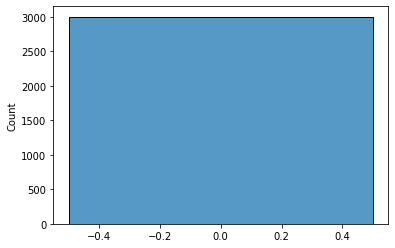

In [236]:
sns.histplot(aco_optimizer.set_pheromones)

In [233]:
ant_solutions = aco_optimizer.execute(iterations=10)
#sns.histplot(aco_optimizer.set_pheromones)

 iteratcio 0: 


Model Logger - INFO - [2021-11-30 00:15:12,333] - >>> Total covering cost: 14390
Model Logger - INFO - [2021-11-30 00:15:12,333] - >>> Total covering cost: 14390
Model Logger - INFO - [2021-11-30 00:15:12,379] - >>> Total covering cost: 19307
Model Logger - INFO - [2021-11-30 00:15:12,386] - >>> Total subsets selected: 7323
Model Logger - INFO - [2021-11-30 00:15:12,386] - >>> Total subsets selected: 7323
Model Logger - INFO - [2021-11-30 00:15:12,379] - >>> Total covering cost: 19307
Model Logger - INFO - [2021-11-30 00:15:12,412] - >>> Total subsets selected: 9830
Model Logger - INFO - [2021-11-30 00:15:12,511] - >>> Total covering cost: 19467
Model Logger - INFO - [2021-11-30 00:15:12,412] - >>> Total subsets selected: 9830
Model Logger - INFO - [2021-11-30 00:15:12,511] - >>> Total covering cost: 19467
Model Logger - INFO - [2021-11-30 00:15:12,525] - >>> Total covering cost: 19818
Model Logger - INFO - [2021-11-30 00:15:12,571] - >>> Total subsets selected: 9911
Model Logger - INF

 iteratcio 1: 


Model Logger - INFO - [2021-11-30 00:15:34,636] - >>> Total covering cost: 2053
Model Logger - INFO - [2021-11-30 00:15:34,654] - >>> Total covering cost: 2465
Model Logger - INFO - [2021-11-30 00:15:34,636] - >>> Total covering cost: 2053
Model Logger - INFO - [2021-11-30 00:15:34,654] - >>> Total covering cost: 2465
Model Logger - INFO - [2021-11-30 00:15:34,667] - >>> Total subsets selected: 1170
Model Logger - INFO - [2021-11-30 00:15:34,669] - >>> Total subsets selected: 1424
Model Logger - INFO - [2021-11-30 00:15:34,667] - >>> Total subsets selected: 1170
Model Logger - INFO - [2021-11-30 00:15:34,669] - >>> Total subsets selected: 1424
Model Logger - INFO - [2021-11-30 00:15:34,698] - >>> Total covering cost: 1726
Model Logger - INFO - [2021-11-30 00:15:34,698] - >>> Total covering cost: 1726
Model Logger - INFO - [2021-11-30 00:15:34,746] - >>> Total covering cost: 2307
Model Logger - INFO - [2021-11-30 00:15:34,752] - >>> Total subsets selected: 989
Model Logger - INFO - [202

 iteratcio 2: 


Model Logger - INFO - [2021-11-30 00:15:41,863] - >>> Total covering cost: 1760
Model Logger - INFO - [2021-11-30 00:15:41,881] - >>> Total covering cost: 2283
Model Logger - INFO - [2021-11-30 00:15:41,863] - >>> Total covering cost: 1760
Model Logger - INFO - [2021-11-30 00:15:41,881] - >>> Total covering cost: 2283
Model Logger - INFO - [2021-11-30 00:15:41,892] - >>> Total subsets selected: 1006
Model Logger - INFO - [2021-11-30 00:15:41,894] - >>> Total subsets selected: 1301
Model Logger - INFO - [2021-11-30 00:15:41,892] - >>> Total subsets selected: 1006
Model Logger - INFO - [2021-11-30 00:15:41,894] - >>> Total subsets selected: 1301
Model Logger - INFO - [2021-11-30 00:15:41,928] - >>> Total covering cost: 1561
Model Logger - INFO - [2021-11-30 00:15:42,055] - >>> Total covering cost: 2001
Model Logger - INFO - [2021-11-30 00:15:42,078] - >>> Total covering cost: 3023
Model Logger - INFO - [2021-11-30 00:15:41,928] - >>> Total covering cost: 1561
Model Logger - INFO - [2021-

 iteratcio 3: 


Model Logger - INFO - [2021-11-30 00:15:49,405] - >>> Total covering cost: 3068
Model Logger - INFO - [2021-11-30 00:15:49,405] - >>> Total covering cost: 3068
Model Logger - INFO - [2021-11-30 00:15:49,474] - >>> Total subsets selected: 1768
Model Logger - INFO - [2021-11-30 00:15:49,474] - >>> Total subsets selected: 1768
Model Logger - INFO - [2021-11-30 00:15:49,503] - >>> Total covering cost: 3258
Model Logger - INFO - [2021-11-30 00:15:49,503] - >>> Total covering cost: 3258
Model Logger - INFO - [2021-11-30 00:15:49,531] - >>> Total subsets selected: 1873
Model Logger - INFO - [2021-11-30 00:15:49,531] - >>> Total covering cost: 3209
Model Logger - INFO - [2021-11-30 00:15:49,531] - >>> Total subsets selected: 1873
Model Logger - INFO - [2021-11-30 00:15:49,531] - >>> Total covering cost: 3209
Model Logger - INFO - [2021-11-30 00:15:49,558] - >>> Total subsets selected: 1852
Model Logger - INFO - [2021-11-30 00:15:49,568] - >>> Total covering cost: 2455
Model Logger - INFO - [20

 iteratcio 4: 


Model Logger - INFO - [2021-11-30 00:15:59,144] - >>> Total covering cost: 1816
Model Logger - INFO - [2021-11-30 00:15:59,144] - >>> Total covering cost: 1816
Model Logger - INFO - [2021-11-30 00:15:59,196] - >>> Total subsets selected: 1037
Model Logger - INFO - [2021-11-30 00:15:59,196] - >>> Total subsets selected: 1037
Model Logger - INFO - [2021-11-30 00:15:59,266] - >>> Total covering cost: 2752
Model Logger - INFO - [2021-11-30 00:15:59,266] - >>> Total covering cost: 2752
Model Logger - INFO - [2021-11-30 00:15:59,305] - >>> Total subsets selected: 1583
Model Logger - INFO - [2021-11-30 00:15:59,305] - >>> Total subsets selected: 1583
Model Logger - INFO - [2021-11-30 00:15:59,366] - >>> Total covering cost: 1691
Model Logger - INFO - [2021-11-30 00:15:59,366] - >>> Total covering cost: 1691
Model Logger - INFO - [2021-11-30 00:15:59,410] - >>> Total subsets selected: 976
Model Logger - INFO - [2021-11-30 00:15:59,410] - >>> Total subsets selected: 976
Model Logger - INFO - [2

 iteratcio 5: 


Model Logger - INFO - [2021-11-30 00:16:10,419] - >>> Total covering cost: 2828
Model Logger - INFO - [2021-11-30 00:16:10,419] - >>> Total covering cost: 2828
Model Logger - INFO - [2021-11-30 00:16:10,450] - >>> Total subsets selected: 1651
Model Logger - INFO - [2021-11-30 00:16:10,450] - >>> Total subsets selected: 1651
Model Logger - INFO - [2021-11-30 00:16:10,695] - >>> Total covering cost: 3616
Model Logger - INFO - [2021-11-30 00:16:10,700] - >>> Total covering cost: 3952
Model Logger - INFO - [2021-11-30 00:16:10,695] - >>> Total covering cost: 3616
Model Logger - INFO - [2021-11-30 00:16:10,700] - >>> Total covering cost: 3952
Model Logger - INFO - [2021-11-30 00:16:10,729] - >>> Total subsets selected: 2093
Model Logger - INFO - [2021-11-30 00:16:10,731] - >>> Total subsets selected: 2275
Model Logger - INFO - [2021-11-30 00:16:10,729] - >>> Total subsets selected: 2093
Model Logger - INFO - [2021-11-30 00:16:10,731] - >>> Total subsets selected: 2275
Model Logger - INFO - 

 iteratcio 6: 


Model Logger - INFO - [2021-11-30 00:16:22,922] - >>> Total covering cost: 3041
Model Logger - INFO - [2021-11-30 00:16:22,922] - >>> Total covering cost: 3041
Model Logger - INFO - [2021-11-30 00:16:22,968] - >>> Total subsets selected: 1783
Model Logger - INFO - [2021-11-30 00:16:22,968] - >>> Total subsets selected: 1783
Model Logger - INFO - [2021-11-30 00:16:23,288] - >>> Total covering cost: 4061
Model Logger - INFO - [2021-11-30 00:16:23,288] - >>> Total covering cost: 4061
Model Logger - INFO - [2021-11-30 00:16:23,309] - >>> Total covering cost: 4475
Model Logger - INFO - [2021-11-30 00:16:23,315] - >>> Total subsets selected: 2328
Model Logger - INFO - [2021-11-30 00:16:23,309] - >>> Total covering cost: 4475
Model Logger - INFO - [2021-11-30 00:16:23,315] - >>> Total subsets selected: 2328
Model Logger - INFO - [2021-11-30 00:16:23,341] - >>> Total subsets selected: 2604
Model Logger - INFO - [2021-11-30 00:16:23,360] - >>> Total covering cost: 3869
Model Logger - INFO - [20

 iteratcio 7: 


Model Logger - INFO - [2021-11-30 00:16:37,329] - >>> Total covering cost: 3351
Model Logger - INFO - [2021-11-30 00:16:37,329] - >>> Total covering cost: 3351
Model Logger - INFO - [2021-11-30 00:16:37,388] - >>> Total subsets selected: 1950
Model Logger - INFO - [2021-11-30 00:16:37,388] - >>> Total covering cost: 3991
Model Logger - INFO - [2021-11-30 00:16:37,388] - >>> Total subsets selected: 1950
Model Logger - INFO - [2021-11-30 00:16:37,388] - >>> Total covering cost: 3991
Model Logger - INFO - [2021-11-30 00:16:37,440] - >>> Total subsets selected: 2326
Model Logger - INFO - [2021-11-30 00:16:37,440] - >>> Total subsets selected: 2326
Model Logger - INFO - [2021-11-30 00:16:37,527] - >>> Total covering cost: 5407
Model Logger - INFO - [2021-11-30 00:16:37,527] - >>> Total covering cost: 5407
Model Logger - INFO - [2021-11-30 00:16:37,596] - >>> Total subsets selected: 3173
Model Logger - INFO - [2021-11-30 00:16:37,596] - >>> Total subsets selected: 3173
Model Logger - INFO - 

 iteratcio 8: 


Model Logger - INFO - [2021-11-30 00:16:57,345] - >>> Total covering cost: 4387
Model Logger - INFO - [2021-11-30 00:16:57,345] - >>> Total covering cost: 4387
Model Logger - INFO - [2021-11-30 00:16:57,425] - >>> Total subsets selected: 2572
Model Logger - INFO - [2021-11-30 00:16:57,425] - >>> Total subsets selected: 2572
Model Logger - INFO - [2021-11-30 00:16:57,818] - >>> Total covering cost: 6398
Model Logger - INFO - [2021-11-30 00:16:57,830] - >>> Total covering cost: 7116
Model Logger - INFO - [2021-11-30 00:16:57,818] - >>> Total covering cost: 6398
Model Logger - INFO - [2021-11-30 00:16:57,830] - >>> Total covering cost: 7116
Model Logger - INFO - [2021-11-30 00:16:57,854] - >>> Total subsets selected: 3748
Model Logger - INFO - [2021-11-30 00:16:57,856] - >>> Total subsets selected: 4218
Model Logger - INFO - [2021-11-30 00:16:57,854] - >>> Total subsets selected: 3748
Model Logger - INFO - [2021-11-30 00:16:57,856] - >>> Total subsets selected: 4218
Model Logger - INFO - 

 iteratcio 9: 


Model Logger - INFO - [2021-11-30 00:17:17,815] - >>> Total covering cost: 4527
Model Logger - INFO - [2021-11-30 00:17:17,815] - >>> Total covering cost: 4527
Model Logger - INFO - [2021-11-30 00:17:17,840] - >>> Total subsets selected: 2662
Model Logger - INFO - [2021-11-30 00:17:17,840] - >>> Total subsets selected: 2662
Model Logger - INFO - [2021-11-30 00:17:17,990] - >>> Total covering cost: 6235
Model Logger - INFO - [2021-11-30 00:17:17,990] - >>> Total covering cost: 6235
Model Logger - INFO - [2021-11-30 00:17:18,022] - >>> Total subsets selected: 3677
Model Logger - INFO - [2021-11-30 00:17:18,022] - >>> Total subsets selected: 3677
Model Logger - INFO - [2021-11-30 00:17:18,103] - >>> Total covering cost: 6035
Model Logger - INFO - [2021-11-30 00:17:18,103] - >>> Total covering cost: 6035
Model Logger - INFO - [2021-11-30 00:17:18,128] - >>> Total subsets selected: 3558
Model Logger - INFO - [2021-11-30 00:17:18,157] - >>> Total covering cost: 5301
Model Logger - INFO - [20

In [177]:
ant_solutions = aco_optimizer.execute(iterations=2)

 iteratcio 0: 


Model Logger - INFO - [2021-11-29 22:33:31,290] - >>> Total covering cost: 15485
Model Logger - INFO - [2021-11-29 22:33:31,290] - >>> Total covering cost: 15485
Model Logger - INFO - [2021-11-29 22:33:31,342] - >>> Total subsets selected: 7936
Model Logger - INFO - [2021-11-29 22:33:31,342] - >>> Total subsets selected: 7936
Model Logger - INFO - [2021-11-29 22:33:31,636] - >>> Total covering cost: 20606
Model Logger - INFO - [2021-11-29 22:33:31,636] - >>> Total covering cost: 20606
Model Logger - INFO - [2021-11-29 22:33:31,672] - >>> Total subsets selected: 10552
Model Logger - INFO - [2021-11-29 22:33:31,672] - >>> Total subsets selected: 10552
Model Logger - INFO - [2021-11-29 22:33:32,307] - >>> Total covering cost: 26019
Model Logger - INFO - [2021-11-29 22:33:32,307] - >>> Total covering cost: 26019
Model Logger - INFO - [2021-11-29 22:33:32,354] - >>> Total subsets selected: 13330
Model Logger - INFO - [2021-11-29 22:33:32,354] - >>> Total subsets selected: 13330
Model Logger

 iteratcio 1: 


Model Logger - INFO - [2021-11-29 22:33:36,249] - >>> Total covering cost: 10084
Model Logger - INFO - [2021-11-29 22:33:36,249] - >>> Total covering cost: 10084
Model Logger - INFO - [2021-11-29 22:33:36,282] - >>> Total subsets selected: 5166
Model Logger - INFO - [2021-11-29 22:33:36,282] - >>> Total subsets selected: 5166
Model Logger - INFO - [2021-11-29 22:33:36,542] - >>> Total covering cost: 14338
Model Logger - INFO - [2021-11-29 22:33:36,542] - >>> Total covering cost: 14338
Model Logger - INFO - [2021-11-29 22:33:36,565] - >>> Total subsets selected: 7348
Model Logger - INFO - [2021-11-29 22:33:36,565] - >>> Total subsets selected: 7348
Model Logger - INFO - [2021-11-29 22:33:36,794] - >>> Total covering cost: 16559
Model Logger - INFO - [2021-11-29 22:33:36,794] - >>> Total covering cost: 16559
Model Logger - INFO - [2021-11-29 22:33:36,818] - >>> Total subsets selected: 8460
Model Logger - INFO - [2021-11-29 22:33:36,818] - >>> Total subsets selected: 8460
Model Logger - I

In [24]:
random.sample([1,2,3], 2)

[2, 1]

# Results reporting and analytics

In [ ]:
from collections import Counter

In [ ]:
len(set_cover_data.sets)

In [ ]:
b_set = set(tuple(x) for x in set_cover_data.sets)
b = [ list(x) for x in b_set ]
len(b)

In [13]:
aco_optimizer

In [ ]:
test = [4,1,2,502]
[item_final_scores[i] for i in test]

In [ ]:
set_cover_instance = SetCovering(set_cover_data.sets, costs=set_cover_data.costs)
min(set_cover_instance.set_scores)

In [ ]:
ant_sol = set_cover_instance.cover()

In [4]:
test_logger = BaseLogger()

In [6]:
test_logger.logger.handlers

[<FileHandler /home/abdala9512/ant-colony-optimization-implementation/notebooks/app.log (NOTSET)>,
 <StreamHandler stderr (NOTSET)>]

In [5]:
np.argsort([10,8,2,5,67])

array([2, 3, 1, 0, 4])

In [1]:
import numpy  as np